<center><h1> KPMG Machine Learning Modelling Part <center><h1>

## Load Libraries for Cleaning and Modelling

In [157]:
import sys
sys.path.append('../../')
from metrics import *

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import mglearn


# Imputing
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Modelling Preparation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold



from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


# Supervised
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import (RandomForestClassifier, 
                              GradientBoostingClassifier,
                              AdaBoostClassifier,
                              BaggingClassifier)

from sklearn.calibration import CalibratedClassifierCV, calibration_curve

import xgboost as xgb
from xgboost import XGBClassifier

import shap
shap.initjs()

# Metrics 
from sklearn.metrics import *

In [2]:
df = pd.read_excel('../../../tagged_round_one.xlsx', sheet_name = 'features_v7', header = 1)

# df = pd.read_excel('./tagged_round_one.xlsx', sheet_name = 'features_v7', header = 1)

In [3]:
df.shape

(41910, 34)

#### Missing data analysis

* `line_height` is completely missing 
* `LS` has some missing values: This means that these lines do not have any LS; hence, we'll encode these to 0. 
* The rest of the missing columns are those that we made ourselves to tag the feature. We will be dropping them. 

In [4]:
df.isna().sum() 

text                         0
document                     0
Name                     31603
Section_Id_Document      41013
Section_ID               41011
Paragraph                40676
Comment                  40752
Class                    34166
df_idx                       0
class                        0
style                        0
id                           0
font-size                    0
vertical-align               0
color                        0
font-family                  0
font-weight                  0
font-style                   0
position                     0
left                         0
top                          0
document_id                  0
page                         0
line-height              41906
Num_Words                    0
String_Length                0
Leading_Char_Upper           0
Leading_Numeral              0
Ends_In_Period               0
Leading_Number_Period        0
Leading_Char_Period          0
Roman_Period                 0
Left_Px 

#### Get document count

In [5]:
num_docs = len(df.groupby('document').count()['text'].rename('Count'))
num_docs

119

#### Drop rows which are not labelled

In [6]:
df = df[df['Class'].isna()==False]

#### See how many documents are done and percentage

In [7]:
num_docs_done = len(df.groupby('document').count()['text'].rename('Count'))

In [8]:
num_docs_done / num_docs

0.31092436974789917

### Extract `first 3 words`,` 5 words`, `first word`, `last word`

In [9]:
df.sample(2)

,text,document,Name,Section_Id_Document,Section_ID,Paragraph,Comment,Class,df_idx,class,...,Num_Words,String_Length,Leading_Char_Upper,Leading_Numeral,Ends_In_Period,Leading_Number_Period,Leading_Char_Period,Roman_Period,Left_Px,LS
3447,Issue. Qualifying entities,html_files/CMS_2014_0115_12938.pdf,pranjal,NaN,NaN,NaN,subsection,0.0,35934,txt,...,3,26,1,0,0,0,0,0,72,28.0
40980,and​ ​the​ ​outcomes​ ​that​ ​are​ a​ ssociate...,html_files/CMS_2014_0115_58449.pdf,Minsu,NaN,NaN,NaN,NaN,0.0,22779,txt,...,20,133,0,0,0,0,0,0,67,13.0


In [10]:
def find_ngrams(input_list, n):
    return list(zip(*[input_list[i:] for i in range(n)]))

In [11]:
### Convert the text column data type to string

import re

df['text'] = df['text'].apply(str)

### Three gram

df['3_grams'] = df['text'].map(lambda x: find_ngrams(x.split(" "), 3))
#df['new_col'] = df.triigrams.apply(lambda x: x[0:1])
df['first_3_words'] = df["3_grams"].str[0]
df['first_3_words'] = df['first_3_words'].apply(str)
df['first_3_words'] = df['first_3_words'].str.replace(r'[^\w\s]+', '')

### Remove stop words from first 3 wodrds

# df['first_3_words'] = df['first_3_words'].apply(lambda x: [item for item in x.split(" ") if item not in stopwords])


### Five gram

df['5_grams'] = df['text'].map(lambda x: find_ngrams(x.split(" "), 5))
df['first_5_words'] = df['5_grams'].str[0]
df['first_5_words'] = df['first_5_words'].apply(str)
df['first_5_words'] = df['first_5_words'].str.replace(r'[^\w\s]+', '')


### I will drop 3-gram and 5_gram columns and keep only fist three words and first five words columns

df = df.drop(['3_grams', '5_grams'], axis = 1)


In [12]:
### Extract first and last word

df["First_Word"] = df["text"].apply(lambda x: x.split()[0:1])
df["First_Word"] = df["First_Word"].apply(str)
df["First_Word"] = df["First_Word"].str.replace(r'[^\w\s]+', '')

df["Last_Word"] = df["text"].apply(lambda x: x.split()[-1:])
df["Last_Word"] = df["Last_Word"].apply(str)
df["Last_Word"] = df["Last_Word"].str.replace(r'[^\w\s]+', '')

#### Note: We don't need the features below since, they'll be captured in the First_Word_Feature anyway 

In [13]:
# #df['Start_conclusion'] = df['First_Word'].str.contains('Conclusion')
# df['Start_conclusion'] = (df['First_Word'].str.contains('Conclusion')) | (df['First_Word'].str.contains('CONCLUSION'))
# df['Start_conclusion'] = df['Start_conclusion'].map({True: 1, False: 0})

# df['Start_Re'] = df['First_Word'].str.contains('Re')
# df['Start_Re'] = df['Start_Re'].map({True: 1, False: 0})
                    
# df['Start_Attention'] = df['First_Word'].str.contains('Attention')
# df['Start_Attention'] = df['Start_Attention'].map({True: 1, False: 0})

In [14]:
# SAVE: Please don't ever save documents in the directory which you will push 
# since we don't want to commit our data to github
df.to_csv('../../../featuresV9.csv')

## Data Cleaning

1. Drop irrelavant columns
2. Convert columns kept to right types 

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7744 entries, 0 to 41909
Data columns (total 38 columns):
text                     7744 non-null object
document                 7744 non-null object
Name                     7744 non-null object
Section_Id_Document      897 non-null float64
Section_ID               899 non-null float64
Paragraph                1234 non-null object
Comment                  1158 non-null object
Class                    7744 non-null float64
df_idx                   7744 non-null int64
class                    7744 non-null object
style                    7744 non-null object
id                       7744 non-null object
font-size                7744 non-null object
vertical-align           7744 non-null object
color                    7744 non-null object
font-family              7744 non-null object
font-weight              7744 non-null object
font-style               7744 non-null object
position                 7744 non-null object
left              

### 1. Drop Irrelavant Columns 
* Drop text since we don't really need it and are using derived features from it 
* Drop columns that we created ourselves for tagging:
`Name`, `section Id document`, `document id`, `section id`, `Comment`, `Paragraph` are not useful since we created them for labelling or target
* `df_idx` is the same thing as document_id and document 
* We keep `document` : we will cat encdode it later 
* Remove `class` (lowercase) since it only has one value
* Drop `position` since it only has one value
* `line height` has nothing in it ... only **nans** 
* Remove `string length` since it's correlated with numwords
* Remove `Left_Px` since it's the same thing as `left` which I clean in the next section
* Remove `style` since it's the same thing as `font+vertical+align+color` which I clean in the next section
* Remove `vertical-align` since it's the same value which is `baseline`
* Remove `id` it is a same as `font-size` 

In [16]:
df = df.drop(['text', 'Name', 'Section_Id_Document', 'document_id',
             'Section_ID', 'Comment', 'Paragraph', 'df_idx' , 'class', 'position',
              'page', 'line-height', 'String_Length', 'Left_Px','style','vertical-align','id'], axis = 1)

Columns that I may remove later:
- `page`: Not sure if it's relevant at all
- `color`: Need to clean it but may not give any feature importance


### 2. Clean columns:  `font_weight`,`font_style`,`fontsize`, `left` and `top`: 

- Change font_weight and font_size to binary
- Remove px and 
- Convert to right data typ

In [17]:
df['font-weight'] = df['font-weight'].map({'bold': 1, 'normal': 0})
df['font-style'] = df['font-style'].map({'italic': 1, 'normal': 0})

df['font-size'] = df['font-size'].str.replace('px', '')
df['font-size'] = pd.to_numeric(df['font-size'])

df['left'] = df['left'].str.replace('px', '')
df['left'] = pd.to_numeric(df['left'])

df['top'] = df['top'].str.replace('px', '')
df['top'] = pd.to_numeric(df['top'])

#### Chage the data type from `int` to `float`

In [18]:
# 'Start_conclusion','Start_Re','Start_Attention'

cols = ['font-weight', 'font-style', 'left', 'top','Num_Words','Leading_Char_Upper','Leading_Numeral','Ends_In_Period','Leading_Number_Period','Leading_Char_Period','Roman_Period']
for col in cols:
    df[col] = df[col].apply(lambda x: float(x))

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7744 entries, 0 to 41909
Data columns (total 21 columns):
document                 7744 non-null object
Class                    7744 non-null float64
font-size                7744 non-null int64
color                    7744 non-null object
font-family              7744 non-null object
font-weight              7744 non-null float64
font-style               7744 non-null float64
left                     7744 non-null float64
top                      7744 non-null float64
Num_Words                7744 non-null float64
Leading_Char_Upper       7744 non-null float64
Leading_Numeral          7744 non-null float64
Ends_In_Period           7744 non-null float64
Leading_Number_Period    7744 non-null float64
Leading_Char_Period      7744 non-null float64
Roman_Period             7744 non-null float64
LS                       7527 non-null float64
first_3_words            7744 non-null object
first_5_words            7744 non-null object
First_

In [20]:
df.to_csv('../../../featuresV10.csv')

#### Impute Missing Column: LS


In [21]:
df['LS'] = df['LS'].fillna(0)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7744 entries, 0 to 41909
Data columns (total 21 columns):
document                 7744 non-null object
Class                    7744 non-null float64
font-size                7744 non-null int64
color                    7744 non-null object
font-family              7744 non-null object
font-weight              7744 non-null float64
font-style               7744 non-null float64
left                     7744 non-null float64
top                      7744 non-null float64
Num_Words                7744 non-null float64
Leading_Char_Upper       7744 non-null float64
Leading_Numeral          7744 non-null float64
Ends_In_Period           7744 non-null float64
Leading_Number_Period    7744 non-null float64
Leading_Char_Period      7744 non-null float64
Roman_Period             7744 non-null float64
LS                       7744 non-null float64
first_3_words            7744 non-null object
first_5_words            7744 non-null object
First_

## Modelling
#### Part I: Data Cleaning and Preparation
1. Separate Target and Data
2. Split into Test and Train
3. Clean Numeric Features 
4. Clean Categorical Features
4. Try NLP Techniques
6. Combine Data Frames

#### Part II: Models
1. Logistic Regression
2. Random Forest
4. Playing with Evaluation Metrics
5. Boosting: AdaBoost and Gradient Boosting
6. Boosting: XGBoost

#### Part III: Pipeline and Tune
1. Parameter Tuning on the Best Model with Pipeline 
2. Change Thresholds
3. Evaluate on Test Set

### Part 1: Prepare

#### 1. Separate Target and Features 

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7744 entries, 0 to 41909
Data columns (total 21 columns):
document                 7744 non-null object
Class                    7744 non-null float64
font-size                7744 non-null int64
color                    7744 non-null object
font-family              7744 non-null object
font-weight              7744 non-null float64
font-style               7744 non-null float64
left                     7744 non-null float64
top                      7744 non-null float64
Num_Words                7744 non-null float64
Leading_Char_Upper       7744 non-null float64
Leading_Numeral          7744 non-null float64
Ends_In_Period           7744 non-null float64
Leading_Number_Period    7744 non-null float64
Leading_Char_Period      7744 non-null float64
Roman_Period             7744 non-null float64
LS                       7744 non-null float64
first_3_words            7744 non-null object
first_5_words            7744 non-null object
First_

In [24]:
df.shape

(7744, 21)

In [25]:
X = df.drop(['Class'], axis = 1)

y = df['Class']

In [26]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7744 entries, 0 to 41909
Data columns (total 20 columns):
document                 7744 non-null object
font-size                7744 non-null int64
color                    7744 non-null object
font-family              7744 non-null object
font-weight              7744 non-null float64
font-style               7744 non-null float64
left                     7744 non-null float64
top                      7744 non-null float64
Num_Words                7744 non-null float64
Leading_Char_Upper       7744 non-null float64
Leading_Numeral          7744 non-null float64
Ends_In_Period           7744 non-null float64
Leading_Number_Period    7744 non-null float64
Leading_Char_Period      7744 non-null float64
Roman_Period             7744 non-null float64
LS                       7744 non-null float64
first_3_words            7744 non-null object
first_5_words            7744 non-null object
First_Word               7744 non-null object
Last_Wo

In [27]:
X.shape

(7744, 20)

#### Check out imbalance

In [28]:
imbalance = (len(y[y == 1]) / len(y)) * 100
print('Class Imblance: {:.2f}%'.format(imbalance))

Class Imblance: 1.89%


#### 2. Train Test Split

In [29]:
# 30% will be selected for testing data randomly
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.30,
                                                    shuffle = True,
                                                    random_state = 9834) 

#### 3. Clean up Numeric features 

In [30]:
X_train_num = X_train.select_dtypes(exclude="object")

In [31]:
X_train_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5420 entries, 3226 to 5064
Data columns (total 13 columns):
font-size                5420 non-null int64
font-weight              5420 non-null float64
font-style               5420 non-null float64
left                     5420 non-null float64
top                      5420 non-null float64
Num_Words                5420 non-null float64
Leading_Char_Upper       5420 non-null float64
Leading_Numeral          5420 non-null float64
Ends_In_Period           5420 non-null float64
Leading_Number_Period    5420 non-null float64
Leading_Char_Period      5420 non-null float64
Roman_Period             5420 non-null float64
LS                       5420 non-null float64
dtypes: float64(12), int64(1)
memory usage: 592.8 KB


In [32]:
X_train_num.sample(3)

,font-size,font-weight,font-style,left,top,Num_Words,Leading_Char_Upper,Leading_Numeral,Ends_In_Period,Leading_Number_Period,Leading_Char_Period,Roman_Period,LS
40337,7,0.0,0.0,72.0,710.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
2831,12,0.0,0.0,72.0,404.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,28.0
765,11,0.0,0.0,72.0,228.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0


#### Split into binary and continuous

In [33]:
X_train_cont = X_train_num[['font-size', 'left', 'top', 'Num_Words', 'LS']]

In [34]:
X_train_binary = X_train_num[['font-weight', 'font-style', 'Leading_Char_Upper',
                'Leading_Numeral', 'Ends_In_Period', 'Leading_Number_Period',
                'Leading_Char_Period', 'Roman_Period']]

In [35]:
print(X_train_cont.shape)
print(X_train_binary.shape)
print(X_train_num.shape)

(5420, 5)
(5420, 8)
(5420, 13)


#### Impute Missing Column: LS: SHOULD NOT IMPUTE HERE; IMPUTE IN PIPELINE 
LS has some missing values: This means that these lines do not have any LS; hence, we'll encode these to 0.

In [36]:
X_train_cont['LS'] = X_train_cont['LS'].fillna(0)

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [37]:
X_train_cont.isna().sum() 

font-size    0
left         0
top          0
Num_Words    0
LS           0
dtype: int64

#### Combine DFs to get X_Numeric

In [38]:
X_train_num = pd.concat([X_train_cont, X_train_binary], axis = 1)

#### 4. Clean up Non-Numeric features

In [39]:
X_train_cat = X_train.select_dtypes(include="object")

In [40]:
X_train_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5420 entries, 3226 to 5064
Data columns (total 7 columns):
document         5420 non-null object
color            5420 non-null object
font-family      5420 non-null object
first_3_words    5420 non-null object
first_5_words    5420 non-null object
First_Word       5420 non-null object
Last_Word        5420 non-null object
dtypes: object(7)
memory usage: 338.8+ KB


In [41]:
X_train_cat.sample(3)

,document,color,font-family,first_3_words,first_5_words,First_Word,Last_Word
3453,html_files/CMS_2014_0115_12938.pdf,"rgba(0,0,0,1)",sans-serif,1 A forprofit,1 A forprofit entity where,1,where
2812,html_files/CMS_2014_0115_12762.pdf,"rgba(0,0,0,1)",sans-serif,nan,nan,,
5454,html_files/CMS_2014_0115_13182.pdf,"rgba(0,0,0,1)",sans-serif,contraceptive coverage requirement,contraceptive coverage requirement for a,contraceptive,of


In [42]:
X_train_text = X_train_cat[['first_3_words', 'first_5_words', 
                'First_Word', 'Last_Word']] # 'Start_Introduction', 'Start_conclusion'

In [43]:
X_train_non_text = X_train_cat[['document', 'color', 'font-family']]

In [44]:
print(X_train_text.shape)
print(X_train_non_text.shape)
print(X_train_cat.shape)

(5420, 4)
(5420, 3)
(5420, 7)


#### OneHotEncode `First Word` Column

In [45]:
one_hot_first_word = pd.get_dummies(X_train_text['First_Word'])

In [46]:
one_hot_first_word.shape

(5420, 2095)

#### OneHotEncode `Last Word` Column

In [47]:
one_hot_last_word = pd.get_dummies(X_train_text['Last_Word'])

In [48]:
one_hot_last_word.shape

(5420, 1986)

#### OneHotEncode Non-Text Columns

In [49]:
sum = 0
for col in X_train_non_text:
    print(len(X_train_non_text[col].unique()))
    sum += len(X_train_non_text[col].unique())
print("Sum =",sum) 

36
18
2
Sum = 56


In [50]:
X_train_non_text = pd.get_dummies(X_train_non_text)

In [51]:
X_train_non_text.shape

(5420, 56)

### NLP Techniques: Get Bag of Words

In [52]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer

In [53]:
first_3_words = X_train_text['first_3_words']

In [54]:
vect_first_3 = CountVectorizer(stop_words='english', ngram_range=(1, 2)).fit(first_3_words)
bag_of_words_first_3 = vect_first_3.transform(first_3_words)

In [55]:
sdf_3 = pd.SparseDataFrame(bag_of_words_first_3,
                         columns=vect_first_3.get_feature_names(), 
                         default_fill_value=0)

In [56]:
first_5_words = X_train_text['first_5_words']

In [57]:
vect_first_5 = CountVectorizer(stop_words='english', ngram_range=(1, 2)).fit(first_5_words)
bag_of_words_first_5 = vect_first_5.transform(first_5_words)

In [58]:
sdf_5 = pd.SparseDataFrame(bag_of_words_first_5,
                         columns=vect_first_5.get_feature_names(), 
                         default_fill_value=0)

#### Stop Words + Ngrams

In [59]:
CountVectorizer(stop_words='english', ngram_range=(1, 2))

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [60]:
TfidfVectorizer(stop_words='english', ngram_range=(1, 2))

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

#### 5. Combine Data Frames

#### Categorical Data: 
1. Keep all non-text columns: OneHotEncoded
2. Create 3 versions:
    * First word
    * First 3 words
    * First 5 words 
 



In [61]:
# reset index for all
X_train_non_text.reset_index(inplace = True)
one_hot_first_word.reset_index(inplace = True)
one_hot_last_word.reset_index(inplace = True)

sdf_3.reset_index(inplace = True)
sdf_5.reset_index(inplace = True)

In [62]:
X_train_cat_1 = pd.concat([X_train_non_text, one_hot_first_word, one_hot_last_word], axis = 1)

In [63]:
X_train_cat_1.head()

,index,document_html_files/CMS_2014_0115_0059.pdf,document_html_files/CMS_2014_0115_0076.pdf,document_html_files/CMS_2014_0115_10379.pdf,document_html_files/CMS_2014_0115_10593.pdf,document_html_files/CMS_2014_0115_11997.pdf,document_html_files/CMS_2014_0115_12304.pdf,document_html_files/CMS_2014_0115_12451.pdf,document_html_files/CMS_2014_0115_12505.pdf,document_html_files/CMS_2014_0115_12528.pdf,...,wwwnyemastercom,wwwpcmanetorg,wwwregulationsgov,wwwwvfroeorg,y,year,yet,you,young,yours
0,3226,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4594,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6594,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,590,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6323,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
print(X_train_non_text.shape)
print(one_hot_first_word.shape)
print(X_train_cat_1.shape)

(5420, 57)
(5420, 2096)
(5420, 4140)


In [65]:
# drop index
X_train_cat_1.drop(['index'], axis = 1, inplace = True)

In [66]:
print(X_train_cat_1.shape)

(5420, 4137)


In [67]:
X_train_cat_2 = pd.concat([X_train_non_text, sdf_3, one_hot_last_word], axis = 1)

In [68]:
print(X_train_non_text.shape)
print(sdf_3.shape)
print(X_train_cat_2.shape)

(5420, 57)
(5420, 6371)
(5420, 8415)


In [69]:
# drop index
X_train_cat_2.drop(['index'], axis = 1, inplace = True)

In [70]:
print(X_train_cat_2.shape)

(5420, 8412)


In [71]:
X_train_cat_3 = pd.concat([X_train_non_text, sdf_5, one_hot_last_word], axis = 1)

In [72]:
print(X_train_non_text.shape)
print(sdf_5.shape)
print(X_train_cat_3.shape)

(5420, 57)
(5420, 10760)
(5420, 12804)


In [73]:
# drop index
X_train_cat_3.drop(['index'], axis = 1, inplace = True)

In [74]:
print(X_train_cat_3.shape)

(5420, 12801)


#### Target-based Encoding to reduce dimensions created by OneHotEncoding

#### Combine Numerical and Categorical

In [75]:
# reset index for all
X_train_num.reset_index(inplace = True)
X_train_cat_1.reset_index(inplace = True)
X_train_cat_2.reset_index(inplace = True)
X_train_cat_3.reset_index(inplace = True)

In [76]:
X_train = pd.concat([X_train_num, X_train_cat_2], axis = 1)

In [77]:
print(X_train_num.shape)
print(X_train_cat_1.shape)
print(X_train.shape)

(5420, 14)
(5420, 4138)
(5420, 8427)


In [78]:
# drop index
X_train.drop(['index'], axis = 1, inplace = True)

In [79]:
print(X_train.shape)

(5420, 8425)


### Part 2: Models

### 1. Logistic Regression

#### 1.1: L2 Penalty

#### Look at cross-validated performance

In [ ]:
lr_scores = cross_val_score(LogisticRegression(), 
                        X_train, y_train, 
                        cv = 5,
                        scoring= 'roc_auc') # cross validation
lr_mean_score = np.mean(lr_scores)

In [ ]:
lr_mean_score

In [ ]:
plt.plot(lr_scores)
plt.axhline(lr_mean_score, color='r', linestyle='--') # plot mean line 
plt.show()

#### Fit one model

In [80]:
lr = LogisticRegression(penalty = 'l2', 
                        C = 1, 
                        class_weight = 'balanced', 
                        solver = 'sag', 
                        max_iter = 100, 
                        random_state = 4896) 
lr.fit(X_train, y_train)

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=4896,
          solver='sag', tol=0.0001, verbose=0, warm_start=False)

In [81]:
y_pred = lr.predict(X_train)

#### Model Performance

In [222]:
def metrics(y, pred):
    print("Accuracy score: {:.2f}".format(accuracy_score(y, pred)))
    print("F1 score: {:.2f}".format(f1_score(y, pred)))
    print("ROC AUC score: {:.2f}".format(roc_auc_score(y, pred)))

In [89]:
metrics(y_train, y_pred)

Accuracy score: 0.81
F1 score: 0.13
ROC AUC score: 0.80


In [223]:
def confusion_metrics(y, pred):
    cm = confusion_matrix(y, pred)
    print("True Negatives:", cm[0][0])
    print("False Negatives:", cm[1][0])
    print("True Positives:", cm[1][1])
    print("False Positives:", cm[0][1])
    print(" ")
    print("Other Metrics:")
    print(" ")
    print("Precision %.2f" % (cm[1][1] / (cm[1][1] + cm[0][1])))
    print("Recall / True Positive Rate %.2f" % (cm[1][1] / (cm[1][1] + cm[1][0])))   
    print("True Negative Rate: %.2f" % (cm[0][0] / (cm[0][0] + cm[0][1])))   

In [92]:
confusion_metrics(y_train, y_pred)

True Negatives: 4298
False Negatives: 22
True Positives: 79
False Positives: 1021
 
Other Metrics:
 
Precision 0.07
Recall / True Positive Rate 0.78
True Negative Rate: 0.81


#### Look at the Important Features

In [224]:
def plot_top_k_feature_importances(coefs, k):    
    # sort 
    args = abs(coefs).argsort()[::-1][:k]    
    # get coefs 
    top_k_coefs = coefs[args]    
    # get column names
    colnames = list(X_train.columns.values[args])
    # plot 
    plt.barh(range(k), top_k_coefs, align='center') 
    plt.yticks(np.arange(k), colnames) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, k)
    plt.show()

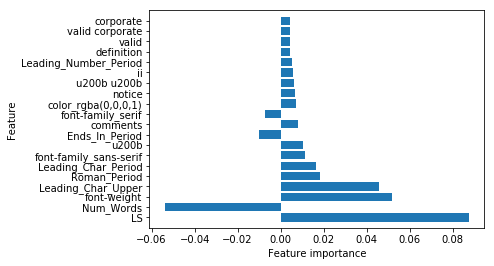

In [95]:
plot_top_k_feature_importances(lr.coef_[0], 20)

#### 1.2: L1 Penalty

In [96]:
lr = LogisticRegression(penalty = 'l1', 
                        C = 1, 
                        class_weight = 'balanced', 
                        # solver = 'sag', 
                        max_iter = 100, 
                        random_state = 4896) 
lr.fit(X_train, y_train)

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=4896,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [97]:
y_pred = lr.predict(X_train)

In [98]:
metrics(y_train, y_pred)

Accuracy score: 0.99
F1 score: 0.74
ROC AUC score: 0.99


In [99]:
confusion_metrics(y_train, y_pred)

True Negatives: 5248
False Negatives: 0
True Positives: 101
False Positives: 71
 
Other Metrics:
 
Precision 0.59
Recall / True Positive Rate 1.00
True Negative Rate: 0.99


#### Look at the Important Features

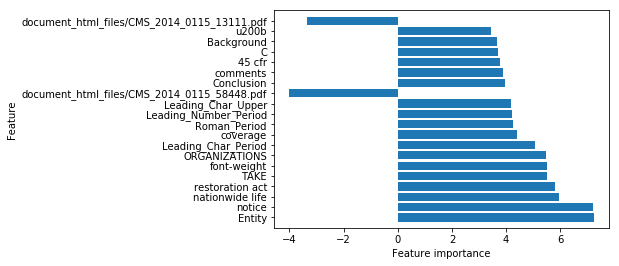

In [100]:
plot_top_k_feature_importances(lr.coef_[0], 20)

### 3. Random Forest

In [228]:
rf = RandomForestClassifier(class_weight = 'balanced') 
rf.fit(X_train, y_train)

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ValueError: could not convert string to float: 'html_files/CMS_2014_0115_12912.pdf'

In [229]:
y_pred = rf.predict(X_train)

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

#### Model Performance

In [103]:
metrics(y_train, y_pred)

Accuracy score: 1.00
F1 score: 0.95
ROC AUC score: 0.95


In [104]:
confusion_metrics(y_train, y_pred)

True Negatives: 5319
False Negatives: 10
True Positives: 91
False Positives: 0
 
Other Metrics:
 
Precision 1.00
Recall / True Positive Rate 0.90
True Negative Rate: 1.00


#### Look at the Important Features

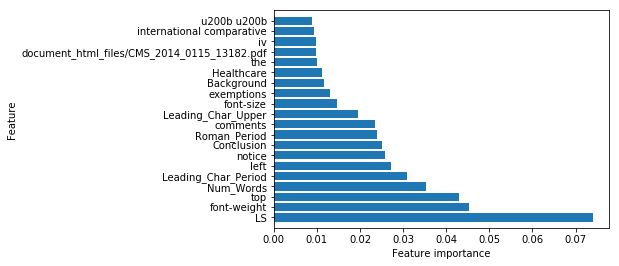

In [105]:
plot_top_k_feature_importances(rf.feature_importances_, 20)

### 5. Boosting: Adaboost

In [106]:
ab = AdaBoostClassifier() 
ab.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [107]:
y_pred = ab.predict(X_train)

#### Model Performance

In [108]:
metrics(y_train, y_pred)

Accuracy score: 0.99
F1 score: 0.82
ROC AUC score: 0.87


In [109]:
confusion_metrics(y_train, y_pred)

True Negatives: 5313
False Negatives: 27
True Positives: 74
False Positives: 6
 
Other Metrics:
 
Precision 0.93
Recall / True Positive Rate 0.73
True Negative Rate: 1.00


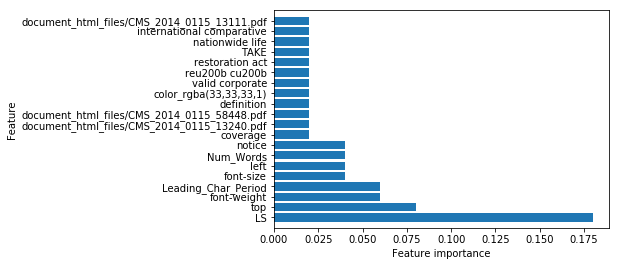

In [110]:
plot_top_k_feature_importances(ab.feature_importances_, 20)

### 5. Boosting: Gradient Boosting

In [111]:
gb = GradientBoostingClassifier() 
gb.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [112]:
y_pred = gb.predict(X_train)

In [113]:
metrics(y_train, y_pred)

Accuracy score: 1.00
F1 score: 0.95
ROC AUC score: 0.97


In [114]:
confusion_metrics(y_train, y_pred)

True Negatives: 5317
False Negatives: 7
True Positives: 94
False Positives: 2
 
Other Metrics:
 
Precision 0.98
Recall / True Positive Rate 0.93
True Negative Rate: 1.00


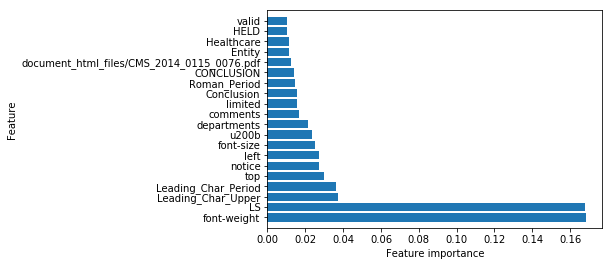

In [115]:
plot_top_k_feature_importances(gb.feature_importances_, 20)

### 6. XGBoost

In [ ]:
X.shape

In [ ]:
y.shape

In [ ]:
X_train.shape

In [ ]:
clf = XGBClassifier(max_depth = 7,
                            eta = 0.05,    
                            learning_rate = 0.01,
                            n_estimators = 500,
                            objective = 'binary:logistic',
                            gamma = 0,
                            reg_alpha = 0,
                            reg_lambda = 0,
                            scale_pos_weight = 1,
                            seed = 9672,
                            missing = None)

In [ ]:
clf.fit(X_train, y_train, verbose=True)
# ,
#         eval_set=[(X_test_encoded, y_test)], early_stopping_rounds=100

In [ ]:
# 30% will be selected for testing data randomly
X_train_sampled, X_val, y_train_sampled, y_val = train_test_split(X_train, y_train,
                                                    test_size = 0.30,
                                                    shuffle = True,
                                                    random_state = 9834) 

In [ ]:
lb_train_encoder_list = []
lb_test_encoder_list = []

encodee_cols = X_train.select_dtypes(exclude=['int','float','bool']).columns

X_train_encoded = X_train_sampled.copy()
X_test_encoded = X_val.copy()

In [ ]:
X_train_encoded.shape

In [ ]:
X_test_encoded.shape

In [ ]:
encodee_cols.shape

In [ ]:
X_train_encoded.dtypes

In [ ]:
for i, c in enumerate(encodee_cols) :
    lb_train_encoder_list.append(LabelEncoder())
    lb_train_encoder_list[i].fit(X_train[c])
    lb_test_encoder_list.append(LabelEncoder())
    lb_test_encoder_list[i].fit(X_test[c])
    
    X_train_encoded = pd.concat([X_train_encoded,
                                 pd.Series(lb_train_encoder_list[i].transform(X_train[c]), name=c+'_encoded')],
                                axis=1)
    
    X_test_encoded = pd.concat([X_test_encoded,
                                 pd.Series(lb_test_encoder_list[i].transform(X_test[c]), name=c+'_encoded')],
                                axis=1)

X_train_encoded.drop(list(encodee_cols), axis=1, inplace=True)
X_test_encoded.drop(list(encodee_cols), axis=1, inplace=True)

In [ ]:
# to prevent XGBoost from being died
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import xgboost
from xgboost import XGBClassifier

In [ ]:
# Max depth typical values: 3-10 
# Typical final values of eta: 0.01-0.2; default=0.3
# one of binary:logistic, multi:softmax, multi:softprob

clf = xgboost.XGBClassifier(max_depth = 7,
                            eta = 0.05,    
                            learning_rate = 0.01,
                            n_estimators = 500,
                            objective = 'binary:logistic',
                            gamma = 0,
                            reg_alpha = 0,
                            reg_lambda = 0,
                            scale_pos_weight = 1,
                            seed = 9672,
                            missing = None)

In [ ]:
clf.fit(X_train_encoded, y_train, verbose=True,
        eval_set=[(X_test_encoded, y_test)], early_stopping_rounds=100)

In [ ]:
y_pred = np.round(clf.predict(X_test_encoded))
y_pro = clf.predict_proba(X_test_encoded)[:, 1]

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

In [ ]:
#X = X_test
X = X_test_encoded
y = y_test
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train_encoded)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [ ]:
shap_values = shap.TreeExplainer(clf).shap_values(X_train_encoded)

In [ ]:
shap.summary_plot(shap_values, X_train_encoded)

In [ ]:
# we pass display_features so we get text display values for age
shap.dependence_plot("LS", shap_values, X_train_encoded)

In [ ]:
y_test.shape, y_pred.shape

In [ ]:
metrics(y_test, y_pred)

In [ ]:
confusion_metrics(y_test, y_pred)

## Part III: Pipeline and Tune
* For this stage, we will use the best model

### 1. Parameter Tuning on the Best Model with Pipeline

#### 1.1 Create the Preprocessing Pipeline

#### Categorical Features

In [165]:
cat_features = list(X.select_dtypes(include="object"))
cat_features.remove('First_Word')
cat_features.remove('Last_Word')
cat_features.remove('first_3_words')
cat_features.remove('first_5_words')
cat_features = cat_features

In [166]:
cat_features

['document', 'color', 'font-family']

#### Text Features

In [119]:
text_features = list(X.select_dtypes(include="object"))
text_features.remove('document')
text_features.remove('color')
text_features.remove('font-family')
text_features = text_features

In [120]:
text_features

['first_3_words', 'first_5_words', 'First_Word', 'Last_Word']

In [121]:
first_1 = [text_features[2], text_features[-1]]
first_3 = [text_features[0], text_features[-1]]
first_5 = [text_features[1], text_features[-1]]

In [208]:
X_train[first_1] = X_train[first_1].astype('U')
X_train[first_3] = X_train[first_1].astype('U')
X_train[first_5] = X_train[first_1].astype('U')

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


#### Numeric Features: We can just borrow from the separations I had made above

In [186]:
list(X.select_dtypes(exclude="object"))

['font-size',
 'font-weight',
 'font-style',
 'left',
 'top',
 'Num_Words',
 'Leading_Char_Upper',
 'Leading_Numeral',
 'Ends_In_Period',
 'Leading_Number_Period',
 'Leading_Char_Period',
 'Roman_Period',
 'LS']

In [187]:
binary_features = list(X_train_binary)

In [188]:
continuous_features = list(X_train_cont)

#### Chain up Transformations

In [209]:
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
                
continuous_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

text_transformer = Pipeline([('vect', TfidfTransformer())])
# count_vect = CountVectorizer(stop_words='english', ngram_range=(1, 2))
# tfidf_vect = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))

In [214]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cont', continuous_transformer, continuous_features),
        ('cat', categorical_transformer, cat_features),
        ('text', text_transformer, first_3)])

In [211]:
final_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(class_weight = 'balanced'))])

#### Put in Pipeline along with text features

In [159]:
pipe_rf = Pipeline([('union', FeatureUnion(
      transformer_list=[('text', Pipeline([('count_vect', 
                                             CountVectorizer(stop_words='english', ngram_range=(1, 2)))])),
                        
                        ('cat', Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])),
                        
                        ('cont', Pipeline(steps=[('scaler', StandardScaler())]))],
    
        transformer_weights={'text': 1.0,'cat': 1.0,'cont': 1.0})),
                    ('classifier', RandomForestClassifier(class_weight = 'balanced'))])

In [204]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.30,
                                                    shuffle = True,
                                                    random_state = 9834) 

In [212]:
param_grid = {'classifier__n_estimators':[10,20,30,40,50,60,70],
               'classifier__max_depth':[5,10,20,30,40,50]}
cv = StratifiedKFold(n_splits=5)

In [239]:
grid_rf = GridSearchCV(final_pipeline, param_grid, cv=5, scoring = 'roc_auc')
grid_rf.fit(X_train, y_train)

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pr

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pr

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pr

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/pr

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/pr

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/pr

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pr

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pr

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/pr

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/pr

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/pr

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/pr

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/pr

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/pr

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/pr

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/pr

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/pr

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/pr

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/pr

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pr

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/pr

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/pr

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/pr

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('cont', Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))]), ['font-size', 'left', 'top', 'Nu...='warn', n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'classifier__n_estimators': [10, 20, 30, 40, 50, 60, 70], 'classifier__max_depth': [5, 10, 20, 30, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [ ]:
grid_rf = GridSearchCV(pipe_rf, param_grid, cv=5, scoring = 'roc_auc')
grid_rf.fit(X_train, y_train)

In [240]:
print("Best Score %s" % grid_rf.best_score_)
print("Best Parameter %s" % grid_rf.best_params_)

Best Score 0.9425048220609928
Best Parameter {'classifier__max_depth': 20, 'classifier__n_estimators': 50}


In [216]:
from sklearn.feature_extraction.text import TfidfTransformer
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}    

### 2. Change Thresholds and Re-evaluate Models

In [242]:
pred_probs = grid_rf.predict_proba(X_train)[:, 1]

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


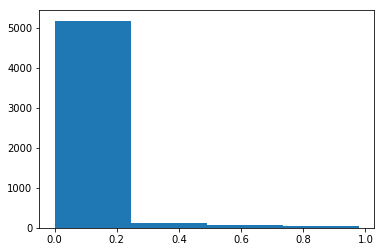

In [243]:
plt.hist(pred_probs, bins=4)
plt.show()

In [248]:
for i in np.arange(0,0.5,0.05):
    y_pred = grid_rf.predict_proba(X_train)[:, 1] > i
    print("")
    print("Metrics")
    print("")
    print(confusion_metrics(y_train, y_pred))

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics

True Negatives: 2891
False Negatives: 0
True Positives: 101
False Positives: 2428
 
Other Metrics:
 
Precision 0.04
Recall / True Positive Rate 1.00
True Negative Rate: 0.54
None

Metrics

True Negatives: 4590
False Negatives: 0
True Positives: 101
False Positives: 729
 
Other Metrics:
 
Precision 0.12
Recall / True Positive Rate 1.00
True Negative Rate: 0.86
None

Metrics

True Negatives: 4918
False Negatives: 0
True Positives: 101
False Positives: 401
 
Other Metrics:
 
Precision 0.20
Recall / True Positive Rate 1.00
True Negative Rate: 0.92
None

Metrics

True Negatives: 5044
False Negatives: 0
True Positives: 101
False Positives: 275
 
Other Metrics:
 
Precision 0.27
Recall / True Positive Rate 1.00
True Negative Rate: 0.95
None

Metrics

True Negatives: 5124
False Negatives: 0
True Positives: 101
False Positives: 195
 
Other Metrics:
 
Precision 0.34
Recall / True Positive Rate 1.00
True Negative Rate: 0.96
None

Metrics

True Negatives: 5184
False Negatives: 0
True Posi

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics

True Negatives: 5256
False Negatives: 0
True Positives: 101
False Positives: 63
 
Other Metrics:
 
Precision 0.62
Recall / True Positive Rate 1.00
True Negative Rate: 0.99
None

Metrics

True Negatives: 5279
False Negatives: 0
True Positives: 101
False Positives: 40
 
Other Metrics:
 
Precision 0.72
Recall / True Positive Rate 1.00
True Negative Rate: 0.99
None

Metrics

True Negatives: 5295
False Negatives: 0
True Positives: 101
False Positives: 24
 
Other Metrics:
 
Precision 0.81
Recall / True Positive Rate 1.00
True Negative Rate: 1.00
None


/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


#### Feature Importances

In [237]:
grid_rf.best_estimator_.named_steps['preprocessor'].transformers_[1][1].get_feature_names()

AttributeError: 'Pipeline' object has no attribute 'get_feature_names'

In [233]:
cat_cols = grid_rf.best_estimator_.named_steps['preprocessor'].transformers_[1][1].get_feature_names()
num_cols = np.asarray(grid_rf.best_estimator_.named_steps['preprocessor'].transformers_[0][2])
one_hot_feature_names_rf = np.concatenate((cat_cols, num_cols), axis = None)

NameError: name 'cat_cols' is not defined

In [ ]:
def plot_coefficients(classifier, feature_names, top_features=10, title='Coefficients'):
    
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]] 
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors) 
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.title(title)
    plt.show()

In [ ]:
plot_coefficients(ols, one_hot_feature_names_rf, top_features=20, title='Coefficients')

### 3. Evaluate on Test Set

In [249]:
grid_rf.score(X_test,y_test)

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.9546633513724343

In [255]:
y_pred = grid_rf.predict(X_test)

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


#### Other Metrics

In [256]:
metrics(y_test, y_pred)

Accuracy score: 0.98
F1 score: 0.20
ROC AUC score: 0.57


In [257]:
confusion_metrics(y_test, y_pred)

True Negatives: 2260
False Negatives: 38
True Positives: 7
False Positives: 19
 
Other Metrics:
 
Precision 0.27
Recall / True Positive Rate 0.16
True Negative Rate: 0.99


In [258]:
classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n         0.0       0.98      0.99      0.99      2279\n         1.0       0.27      0.16      0.20        45\n\n   micro avg       0.98      0.98      0.98      2324\n   macro avg       0.63      0.57      0.59      2324\nweighted avg       0.97      0.98      0.97      2324\n'

#### Thresholding

In [261]:
pred_probs = grid_rf.predict_proba(X_test)[:, 1] 

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


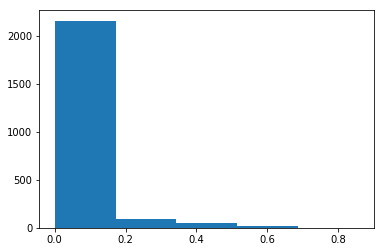

In [263]:
plt.hist(pred_probs, bins=5)
plt.show()

In [266]:
for i in np.arange(0,0.5,0.01):
    y_pred = grid_rf.predict_proba(X_test)[:, 1] > i
    print("")
    print("Metrics")
    print("Threshold =", i)
    print("")
    print(metrics(y_test, y_pred))
    print(confusion_metrics(y_test, y_pred))

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/k


Metrics
Threshold = 0.0

Accuracy score: 0.54
F1 score: 0.08
ROC AUC score: 0.77
None
True Negatives: 1213
False Negatives: 0
True Positives: 45
False Positives: 1066
 
Other Metrics:
 
Precision 0.04
Recall / True Positive Rate 1.00
True Negative Rate: 0.53
None

Metrics
Threshold = 0.01

Accuracy score: 0.60
F1 score: 0.09
ROC AUC score: 0.80
None
True Negatives: 1360
False Negatives: 0
True Positives: 45
False Positives: 919
 
Other Metrics:
 
Precision 0.05
Recall / True Positive Rate 1.00
True Negative Rate: 0.60
None

Metrics
Threshold = 0.02

Accuracy score: 0.73
F1 score: 0.13
ROC AUC score: 0.86
None
True Negatives: 1659
False Negatives: 0
True Positives: 45
False Positives: 620
 
Other Metrics:
 
Precision 0.07
Recall / True Positive Rate 1.00
True Negative Rate: 0.73
None

Metrics
Threshold = 0.03

Accuracy score: 0.76
F1 score: 0.14
ROC AUC score: 0.88
None
True Negatives: 1724
False Negatives: 0
True Positives: 45
False Positives: 555
 
Other Metrics:
 
Precision 0.07
Rec

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/k


Metrics
Threshold = 0.05

Accuracy score: 0.84
F1 score: 0.20
ROC AUC score: 0.92
None
True Negatives: 1915
False Negatives: 0
True Positives: 45
False Positives: 364
 
Other Metrics:
 
Precision 0.11
Recall / True Positive Rate 1.00
True Negative Rate: 0.84
None

Metrics
Threshold = 0.06

Accuracy score: 0.87
F1 score: 0.22
ROC AUC score: 0.91
None
True Negatives: 1970
False Negatives: 2
True Positives: 43
False Positives: 309
 
Other Metrics:
 
Precision 0.12
Recall / True Positive Rate 0.96
True Negative Rate: 0.86
None

Metrics
Threshold = 0.07

Accuracy score: 0.88
F1 score: 0.24
ROC AUC score: 0.92
None
True Negatives: 2003
False Negatives: 2
True Positives: 43
False Positives: 276
 
Other Metrics:
 
Precision 0.13
Recall / True Positive Rate 0.96
True Negative Rate: 0.88
None

Metrics
Threshold = 0.08

Accuracy score: 0.89
F1 score: 0.24
ROC AUC score: 0.90
None
True Negatives: 2020
False Negatives: 4
True Positives: 41
False Positives: 259
 
Other Metrics:
 
Precision 0.14
Rec

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/k


Metrics
Threshold = 0.16

Accuracy score: 0.93
F1 score: 0.29
ROC AUC score: 0.83
None
True Negatives: 2131
False Negatives: 12
True Positives: 33
False Positives: 148
 
Other Metrics:
 
Precision 0.18
Recall / True Positive Rate 0.73
True Negative Rate: 0.94
None

Metrics
Threshold = 0.17

Accuracy score: 0.94
F1 score: 0.30
ROC AUC score: 0.84
None
True Negatives: 2140
False Negatives: 12
True Positives: 33
False Positives: 139
 
Other Metrics:
 
Precision 0.19
Recall / True Positive Rate 0.73
True Negative Rate: 0.94
None

Metrics
Threshold = 0.18

Accuracy score: 0.94
F1 score: 0.30
ROC AUC score: 0.82
None
True Negatives: 2149
False Negatives: 14
True Positives: 31
False Positives: 130
 
Other Metrics:
 
Precision 0.19
Recall / True Positive Rate 0.69
True Negative Rate: 0.94
None

Metrics
Threshold = 0.19

Accuracy score: 0.94
F1 score: 0.31
ROC AUC score: 0.82
None
True Negatives: 2158
False Negatives: 14
True Positives: 31
False Positives: 121
 
Other Metrics:
 
Precision 0.20

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/k


Metrics
Threshold = 0.22

Accuracy score: 0.95
F1 score: 0.31
ROC AUC score: 0.79
None
True Negatives: 2173
False Negatives: 17
True Positives: 28
False Positives: 106
 
Other Metrics:
 
Precision 0.21
Recall / True Positive Rate 0.62
True Negative Rate: 0.95
None

Metrics
Threshold = 0.23

Accuracy score: 0.95
F1 score: 0.31
ROC AUC score: 0.78
None
True Negatives: 2175
False Negatives: 18
True Positives: 27
False Positives: 104
 
Other Metrics:
 
Precision 0.21
Recall / True Positive Rate 0.60
True Negative Rate: 0.95
None

Metrics
Threshold = 0.24

Accuracy score: 0.95
F1 score: 0.31
ROC AUC score: 0.78
None
True Negatives: 2176
False Negatives: 18
True Positives: 27
False Positives: 103
 
Other Metrics:
 
Precision 0.21
Recall / True Positive Rate 0.60
True Negative Rate: 0.95
None

Metrics
Threshold = 0.25

Accuracy score: 0.95
F1 score: 0.31
ROC AUC score: 0.77
None
True Negatives: 2183
False Negatives: 19
True Positives: 26
False Positives: 96
 
Other Metrics:
 
Precision 0.21


/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/k


Metrics
Threshold = 0.28

Accuracy score: 0.95
F1 score: 0.31
ROC AUC score: 0.75
None
True Negatives: 2194
False Negatives: 21
True Positives: 24
False Positives: 85
 
Other Metrics:
 
Precision 0.22
Recall / True Positive Rate 0.53
True Negative Rate: 0.96
None

Metrics
Threshold = 0.29

Accuracy score: 0.96
F1 score: 0.31
ROC AUC score: 0.74
None
True Negatives: 2199
False Negatives: 22
True Positives: 23
False Positives: 80
 
Other Metrics:
 
Precision 0.22
Recall / True Positive Rate 0.51
True Negative Rate: 0.96
None

Metrics
Threshold = 0.3

Accuracy score: 0.96
F1 score: 0.31
ROC AUC score: 0.73
None
True Negatives: 2205
False Negatives: 23
True Positives: 22
False Positives: 74
 
Other Metrics:
 
Precision 0.23
Recall / True Positive Rate 0.49
True Negative Rate: 0.97
None

Metrics
Threshold = 0.31

Accuracy score: 0.96
F1 score: 0.25
ROC AUC score: 0.67
None
True Negatives: 2206
False Negatives: 28
True Positives: 17
False Positives: 73
 
Other Metrics:
 
Precision 0.19
Reca

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/k


Metrics
Threshold = 0.33

Accuracy score: 0.96
F1 score: 0.26
ROC AUC score: 0.67
None
True Negatives: 2212
False Negatives: 28
True Positives: 17
False Positives: 67
 
Other Metrics:
 
Precision 0.20
Recall / True Positive Rate 0.38
True Negative Rate: 0.97
None

Metrics
Threshold = 0.34

Accuracy score: 0.96
F1 score: 0.28
ROC AUC score: 0.68
None
True Negatives: 2218
False Negatives: 28
True Positives: 17
False Positives: 61
 
Other Metrics:
 
Precision 0.22
Recall / True Positive Rate 0.38
True Negative Rate: 0.97
None

Metrics
Threshold = 0.35000000000000003

Accuracy score: 0.96
F1 score: 0.27
ROC AUC score: 0.67
None
True Negatives: 2221
False Negatives: 29
True Positives: 16
False Positives: 58
 
Other Metrics:
 
Precision 0.22
Recall / True Positive Rate 0.36
True Negative Rate: 0.97
None

Metrics
Threshold = 0.36

Accuracy score: 0.96
F1 score: 0.28
ROC AUC score: 0.67
None
True Negatives: 2224
False Negatives: 29
True Positives: 16
False Positives: 55
 
Other Metrics:
 
Pre

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/k


Metrics
Threshold = 0.38

Accuracy score: 0.97
F1 score: 0.25
ROC AUC score: 0.63
None
True Negatives: 2232
False Negatives: 32
True Positives: 13
False Positives: 47
 
Other Metrics:
 
Precision 0.22
Recall / True Positive Rate 0.29
True Negative Rate: 0.98
None

Metrics
Threshold = 0.39

Accuracy score: 0.97
F1 score: 0.24
ROC AUC score: 0.62
None
True Negatives: 2234
False Negatives: 33
True Positives: 12
False Positives: 45
 
Other Metrics:
 
Precision 0.21
Recall / True Positive Rate 0.27
True Negative Rate: 0.98
None

Metrics
Threshold = 0.4

Accuracy score: 0.97
F1 score: 0.23
ROC AUC score: 0.61
None
True Negatives: 2239
False Negatives: 34
True Positives: 11
False Positives: 40
 
Other Metrics:
 
Precision 0.22
Recall / True Positive Rate 0.24
True Negative Rate: 0.98
None

Metrics
Threshold = 0.41000000000000003

Accuracy score: 0.97
F1 score: 0.22
ROC AUC score: 0.60
None
True Negatives: 2243
False Negatives: 35
True Positives: 10
False Positives: 36
 
Other Metrics:
 
Prec

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/k


Metrics
Threshold = 0.43

Accuracy score: 0.97
F1 score: 0.19
ROC AUC score: 0.58
None
True Negatives: 2246
False Negatives: 37
True Positives: 8
False Positives: 33
 
Other Metrics:
 
Precision 0.20
Recall / True Positive Rate 0.18
True Negative Rate: 0.99
None

Metrics
Threshold = 0.44

Accuracy score: 0.97
F1 score: 0.20
ROC AUC score: 0.58
None
True Negatives: 2250
False Negatives: 37
True Positives: 8
False Positives: 29
 
Other Metrics:
 
Precision 0.22
Recall / True Positive Rate 0.18
True Negative Rate: 0.99
None

Metrics
Threshold = 0.45

Accuracy score: 0.97
F1 score: 0.20
ROC AUC score: 0.58
None
True Negatives: 2252
False Negatives: 37
True Positives: 8
False Positives: 27
 
Other Metrics:
 
Precision 0.23
Recall / True Positive Rate 0.18
True Negative Rate: 0.99
None

Metrics
Threshold = 0.46

Accuracy score: 0.97
F1 score: 0.20
ROC AUC score: 0.58
None
True Negatives: 2253
False Negatives: 37
True Positives: 8
False Positives: 26
 
Other Metrics:
 
Precision 0.24
Recall 

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/k


Metrics
Threshold = 0.48

Accuracy score: 0.98
F1 score: 0.22
ROC AUC score: 0.58
None
True Negatives: 2258
False Negatives: 37
True Positives: 8
False Positives: 21
 
Other Metrics:
 
Precision 0.28
Recall / True Positive Rate 0.18
True Negative Rate: 0.99
None

Metrics
Threshold = 0.49

Accuracy score: 0.97
F1 score: 0.19
ROC AUC score: 0.57
None
True Negatives: 2258
False Negatives: 38
True Positives: 7
False Positives: 21
 
Other Metrics:
 
Precision 0.25
Recall / True Positive Rate 0.16
True Negative Rate: 0.99
None


/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


##### EXTRA: GridSearch With Wrapper with refit = recall score

In [ ]:
def grid_search_wrapper(refit_score='accuracy_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(pipe_rf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # make the predictions
    y_pred = grid_search.predict(X_test)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [ ]:
grid_search_clf = grid_search_wrapper(refit_score='accuracy_score')
grid_search_clf.fit(X_train, y_train)


In [ ]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_precision_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score'
         ]].head(10)

In [ ]:
y_pred = grid_search_clf.best_estimator_.predict(X_train)
y_pred_class = grid_search_clf.best_estimator_.predict(X_test)

In [ ]:
print("Test Accuracy score: {:.2f}".format(accuracy_score(y_test, y_pred_class)))
print("Test F1 score: {:.2f}".format(f1_score(y_test, y_pred_class)))

In [ ]:
print("Train Accuracy score: {:.2f}".format(accuracy_score(y_train, y_pred)))
print("Train F1 score: {:.2f}".format(f1_score(y_train, y_pred)))

In [ ]:
print (classification_report(y_test, y_pred_class))